<a href="https://colab.research.google.com/github/Private-ML/gan/blob/card_gan/SimpleCardGan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from google.colab import drive
GDRIVE_PATH = '/content/gdrive'
THIS_EXERCISE_PATH = os.path.join(GDRIVE_PATH, "My Drive", "CreditCardGan")
MODELS_HOME = os.path.join(THIS_EXERCISE_PATH, "models")
drive.mount(GDRIVE_PATH)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.makedirs(THIS_EXERCISE_PATH, exist_ok=True)
os.makedirs(MODELS_HOME, exist_ok=True)

In [0]:
import pandas as pd
data = pd.read_csv('https://query.data.world/s/zruvk5e5icrymfmrwrihhzbuaha37h')

In [0]:
data

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import pickle

In [0]:
LATENT_DIM = 30
FEATURES = len(data.keys())
FEATURES

31

In [0]:
from sklearn.preprocessing import QuantileTransformer

transformator = QuantileTransformer(output_distribution='normal')
data_transformed = np.array(transformator.fit_transform(data), dtype='float')
train, test = train_test_split(data_transformed, test_size=0.1, random_state=42)

In [0]:
with open(os.path.join(MODELS_HOME, 'transformer'), 'wb') as file:
    pickle.dump(transformator, file)

In [0]:
GENERATOR_FILE = os.path.join(MODELS_HOME, 'generator.pt')
DISCRIMINATOR_FILE = os.path.join(MODELS_HOME, 'discriminator.pt')
try:
  gen = torch.load(GENERATOR_FILE)
  disc = torch.load(DISCRIMINATOR_FILE)
except FileNotFoundError:
  print("building new models")
  gen = nn.Sequential(nn.Linear(LATENT_DIM, 30), nn.ReLU(),
                    nn.Linear(30, 30), nn.ReLU(),
                    nn.Linear(30, 30), nn.ReLU(),
                    nn.Linear(30, 30), nn.ReLU(),
                    nn.Linear(30, 30), nn.ReLU(),
                    nn.Linear(30, FEATURES)).cuda()

  disc = nn.Sequential(nn.Linear(FEATURES, 30), nn.ReLU(),
                     nn.Linear(30, 30), nn.ReLU(),
                     nn.Linear(30, 30), nn.ReLU(),
                     nn.Linear(30, 30), nn.ReLU(),
                     nn.Linear(30, 30), nn.ReLU(),
                     nn.Linear(30, 1)).cuda()

building new models


In [0]:
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=1e-4)
gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_opt, milestones=[10000, 30000], gamma=0.1)

disc_opt = torch.optim.RMSprop(disc.parameters(), lr=1e-4)
disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(disc_opt, milestones=[10000, 30000], gamma=0.1)

In [0]:
TRAIN_BATCH_SIZE = 1024
def sample_real_data(batch_size):
  ids = np.random.choice(len(train), size=batch_size)
  return torch.tensor(train[ids], device="cuda", dtype=torch.float)

In [0]:
def sample_gen_data(batch_size):
  noise = torch.rand(batch_size, LATENT_DIM, device="cuda")
  return gen(noise)

In [0]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py
def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
  """
  Computes Gradient Penalty in random interpolates, in its classic form:
  (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
  Args:
    critic: a torch model whose gradient needs to be penalised
    real_data[batch_size, n_features]: a sample of real data
    fakse_data[batch_size, n_features]: a sample of fake data
  Returns:
    torch.Tensor, scalar, gradient penalty evalute
  """
  assert real_data.shape == fake_data.shape
  alpha = torch.rand(real_data.shape[0], 1)
  alpha = alpha.expand(real_data.size()).cuda()

  interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
  interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

  disc_interpolates = critic(interpolates)

  gradients = torch.autograd.grad(
      outputs=disc_interpolates, inputs=interpolates,
      grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
      create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

In [0]:
LAMBDA = 1.
def train_disc(gan_type="WGAN-GP"):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = sample_real_data(TRAIN_BATCH_SIZE).to("cuda")
    gen_data = sample_gen_data(TRAIN_BATCH_SIZE)
    
    if gan_type == "JS":
      disc_loss = -logsigmoid(disc(
              real_data
          )).mean() - \
          logsigmoid(-disc(
              gen_data
          )).mean()
    elif gan_type == "WGAN-GP":
      disc_loss = -disc(
              real_data
          ).mean() + \
          disc(
              gen_data
          ).mean() + \
                  calc_gradient_penalty_classic(disc, real_data, gen_data)*LAMBDA
    else:
      raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss

In [0]:
def train_gen(gan_type="WGAN-GP"):
    """Trains generator for one step"""
    gen_data = sample_gen_data(TRAIN_BATCH_SIZE)
    
    if gan_type == "JS":
      gen_loss = -logsigmoid(disc(
              gen_data
          )).mean()
    elif gan_type == "WGAN-GP":
      gen_loss = -disc(
              gen_data
          ).mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "cardv1"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

In [0]:
%load_ext tensorboard

In [0]:
%tensorboard --logdir ./logs

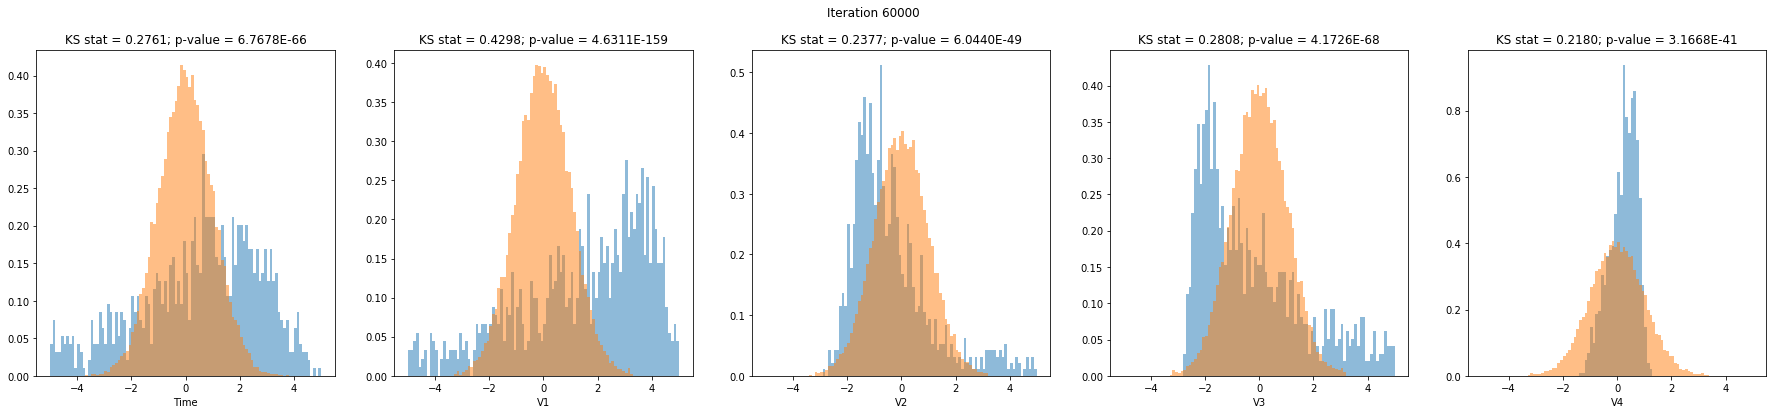

In [0]:
from torch.nn.functional import logsigmoid
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 200
SAVE_INTERVAL = 500
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]

validation_data = torch.from_numpy(test).cuda()
validation_data_np = test

for i in range(100000):
    gen_scheduler.step()
    disc_scheduler.step()
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        disc_loss_this_iter = train_disc()
    
    gen_loss_this_iter = train_gen()

    summary_writer.add_scalar("discriminator loss", disc_loss_this_iter,
                              global_step=i)
    summary_writer.add_scalar("generator loss", gen_loss_this_iter,
                              global_step=i)

    if i % SAVE_INTERVAL == 0:
        torch.save(gen, GENERATOR_FILE)
        torch.save(disc, DISCRIMINATOR_FILE)

    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)        
        validation_generated = sample_gen_data(TRAIN_BATCH_SIZE)
        validation_generated_np = validation_generated.data.cpu().numpy()
        
        fig, axes_list = plt.subplots(ncols=5, figsize=[FEATURES, 6])
        for index, ax in enumerate(axes_list):
          ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
          ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Real', bins=HIST_BINS)
          ax.set_xlabel(data.columns[index])
          ks_result = ks_2samp(validation_generated_np[:, index],
                                    validation_data_np[:, index])
          ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
        fig.suptitle("Iteration {}".format(i))
        plt.show()

In [0]:
gen = torch.load(GENERATOR_FILE)
disc = torch.load(DISCRIMINATOR_FILE)